In [1]:
import time
from pathlib import Path
from typing import Callable, Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchdiffeq import odeint


class AnalyticRetardation:
    @staticmethod
    def linear(u, por, rho_s, Kd):
        factor = 1 + (1 - por) / por * rho_s * Kd
        ones_like_u = u * 0 + 1
        return ones_like_u * factor

    @staticmethod
    def freundlich(u, por, rho_s, Kf, nf):
        return 1 + (1 - por) / por * rho_s * Kf * nf * (u + 1e-6) ** (nf - 1)

    @staticmethod
    def langmuir(u, por, rho_s, smax, Kl):
        return 1 + (1 - por) / por * rho_s * smax * Kl / ((u + Kl) ** 2)


def create_mlp(layers: list[int], activation_fun, activation_fun_end, dropout: int = 0):
    network_layers = []

    for i in range(len(layers) - 1):
        network_layers.append(nn.Linear(layers[i], layers[i + 1]))
        if i < len(layers) - 2:
            network_layers.append(activation_fun)
            if dropout > 0:
                print("Adding dropout")
                network_layers.append(nn.Dropout(p=dropout / 100.0))

    network_layers.append(activation_fun_end)

    return nn.Sequential(*network_layers)


class Flux_Kernels(nn.Module):
    def __init__(self, u0, cfg, var_idx, ret_inv_fun=None):
        """
        Constructor
        Inputs:
            u0      : initial condition, dim: [Nx, Ny]
            cfg     : configuration object of the model setup, containing boundary
                        condition types, values, learnable parameter settings, etc.
            var_idx : index of the calculated variable (could be > 1 for coupled
                        systems)
        """

        super(Flux_Kernels, self).__init__()

        self.Nx = u0.size(0)
        self.Ny = u0.size(1)
        self.u0 = u0

        # Variables that act as switch to use different types of boundary
        # condition
        # Each variable consists of boolean values at all 2D domain boundaries:
        # [left (x = 0), right (x = Nx), top (y = 0), bottom (y = Ny)]
        # For 1D, only the first two values matter, set the last two values to
        # be no-flux boundaries (zero neumann_val)
        self.dirichlet_bool = cfg.dirichlet_bool[var_idx]
        self.neumann_bool = cfg.neumann_bool[var_idx]
        self.cauchy_bool = cfg.cauchy_bool[var_idx]

        # Variables that store the values of the boundary condition of each type
        # Values = 0 if not used, otherwise specify in the configuration file
        # Each variable consists of real values at all 2D domain boundaries:
        # [left (x = 0), right (x = Nx), top (y = 0), bottom (y = Ny)]
        # For 1D, only the first two values matter, set the last two values to
        # be no-flux boundaries
        if torch.is_tensor(cfg.dirichlet_val[var_idx]):
            self.dirichlet_val = cfg.dirichlet_val[var_idx]
        else:
            self.dirichlet_val = torch.tensor(cfg.dirichlet_val[var_idx])

        if torch.is_tensor(cfg.neumann_val[var_idx]):
            self.neumann_val = cfg.neumann_val[var_idx]
        else:
            self.neumann_val = torch.tensor(cfg.neumann_val[var_idx])

        # For Cauchy BC, the initial Cauchy value is set to be the initial
        # condition at each corresponding domain boundary, and will be updated
        # through time
        self.cauchy_val = []
        self.cauchy_val.append(u0[0, :])
        self.cauchy_val.append(u0[-1, :])
        self.cauchy_val.append(u0[:, 0])
        self.cauchy_val.append(u0[:, -1])

        # Set the Cauchy BC multiplier (to be multiplied with the gradient of
        # the unknown variable and the diffusion coefficient)
        if torch.is_tensor(cfg.cauchy_mult[var_idx]):
            self.cauchy_mult = cfg.cauchy_mult[var_idx]
        else:
            self.cauchy_mult = torch.tensor(cfg.cauchy_mult[var_idx])

        # If numerical stencil is to be learned, initialize to +1 and -1 with
        # a standard deviation of 0.1 each, otherwise set it to fixed values
        self.learn_stencil = cfg.learn_stencil[var_idx]
        if self.learn_stencil:
            self.stencil = torch.tensor(
                [
                    torch.normal(torch.tensor([1.0]), torch.tensor([0.1])),
                    torch.normal(torch.tensor([-1.0]), torch.tensor([0.1])),
                ],
                dtype=torch.float,
            )
            self.stencil = nn.Parameter(self.stencil)
        else:
            self.stencil = torch.tensor([1.0, -1.0])

        if torch.is_tensor(cfg.D_eff[var_idx]):
            self.D_eff = cfg.D_eff[var_idx]
        else:
            self.D_eff = torch.tensor(cfg.D_eff[var_idx])
        if cfg.learn_coeff[var_idx]:
            self.D_eff = nn.Parameter(torch.tensor([self.D_eff], dtype=torch.float))

        self.is_retardation_a_func = cfg.is_retardation_a_func[var_idx]

        # Extract value of the normalizing constant to be applied to the output
        # of the NN that predicts the diffusion coefficient function
        self.p_exp = torch.tensor(cfg.p_exp_flux[var_idx])

        # Initialize a NN to predict retardation factor as a function of
        # the unknown variable if necessary
        if ret_inv_fun is not None:
            self.ret_inv_fun = ret_inv_fun
            self.p_exp = nn.Parameter(torch.tensor([self.p_exp], dtype=torch.float))

    def forward(self, u_main, u_coupled, t):
        if u_coupled.shape[0] != 1:
            u_coupled = u_coupled.unsqueeze(0)
        u_coupled = u_coupled.permute(1, 2, 0)

        # Calculate the flux multiplier (retardation function) if set
        # to be a function, otherwise set as tensor of ones
        if self.is_retardation_a_func:
            ret_inv = self.ret_inv_fun(u_coupled).squeeze(2) * 10**self.p_exp
        else:
            ret_inv = torch.ones(self.Nx, self.Ny)

        # Squeeze the u_main dimension into [Nx, Ny]
        u_main = u_main.squeeze(0)

        # Left Boundary Condition
        if self.dirichlet_bool[0]:
            # If Dirichlet, calculate the flux at the boundary using the
            # Dirichlet value as a constant
            left_bound_flux = (
                (
                    self.stencil[0] * self.dirichlet_val[0]
                    + self.stencil[1] * u_main[0, :]
                ).unsqueeze(0)
                * self.D_eff
                * ret_inv[0, :]
            )

        elif self.neumann_bool[0]:
            # If Neumann, set the Neumann value as the flux at the boundary
            left_bound_flux = torch.cat(
                self.Ny * [self.neumann_val[0].unsqueeze(0)]
            ).unsqueeze(0)

        elif self.cauchy_bool[0]:
            # If Cauchy, first set the value to be equal to the initial condition
            # at t = 0.0, otherwise update the value according to the previous
            # time step value
            if t == 0.0:
                self.cauchy_val[0] = self.u0[0, :]
            else:
                self.cauchy_val[0] = (
                    (u_main[0, :] - self.cauchy_val[0]) * self.cauchy_mult * self.D_eff
                )
            # Calculate the flux at the boundary using the updated Cauchy value
            left_bound_flux = (
                (
                    self.stencil[0] * self.cauchy_val[0]
                    + self.stencil[1] * u_main[0, :]
                ).unsqueeze(0)
                * self.D_eff
                * ret_inv[0, :]
            )

        # Calculate the fluxes of each control volume with its left neighboring cell
        left_neighbors = (
            (self.stencil[0] * u_main[:-1, :] + self.stencil[1] * u_main[1:, :])
            * self.D_eff
            * ret_inv[1:, :]
        )
        # Concatenate the left boundary fluxes with the left neighbors fluxes
        left_flux = torch.cat((left_bound_flux, left_neighbors))

        # Right Boundary Condition
        if self.dirichlet_bool[1]:
            # If Dirichlet, calculate the flux at the boundary using the
            # Dirichlet value as a constant
            right_bound_flux = (
                (
                    self.stencil[0] * self.dirichlet_val[1]
                    + self.stencil[1] * u_main[-1, :]
                ).unsqueeze(0)
                * self.D_eff
                * ret_inv[-1, :]
            )

        elif self.neumann_bool[1]:
            # If Neumann, set the Neumann value as the flux at the boundary
            right_bound_flux = torch.cat(
                self.Ny * [self.neumann_val[1].unsqueeze(0)]
            ).unsqueeze(0)

        elif self.cauchy_bool[1]:
            # If Cauchy, first set the value to be equal to the initial condition
            # at t = 0.0, otherwise update the value according to the previous
            # time step value
            if t == 0.0:
                self.cauchy_val[1] = self.u0[-1, :]
            else:
                self.cauchy_val[1] = (
                    (u_main[-1, :] - self.cauchy_val[1]) * self.cauchy_mult * self.D_eff
                )
            # Calculate the flux at the boundary using the updated Cauchy value
            right_bound_flux = (
                (
                    self.stencil[0] * self.cauchy_val[1]
                    + self.stencil[1] * u_main[-1, :]
                ).unsqueeze(0)
                * self.D_eff
                * ret_inv[-1, :]
            )

        # Calculate the fluxes of each control volume with its right neighboring cell
        right_neighbors = (
            (self.stencil[0] * u_main[1:, :] + self.stencil[1] * u_main[:-1, :])
            * self.D_eff
            * ret_inv[:-1, :]
        )
        # Concatenate the right neighbors fluxes with the right boundary fluxes
        right_flux = torch.cat((right_neighbors, right_bound_flux))

        # Top Boundary Condition
        if self.dirichlet_bool[2]:
            # If Dirichlet, calculate the flux at the boundary using the
            # Dirichlet value as a constant
            top_bound_flux = (
                (
                    self.stencil[0] * self.dirichlet_val[2]
                    + self.stencil[1] * u_main[:, 0]
                ).unsqueeze(1)
                * self.D_eff
                * ret_inv[:, 0]
            )

        elif self.neumann_bool[2]:
            # If Neumann, set the Neumann value as the flux at the boundary
            top_bound_flux = torch.cat(
                self.Nx * [self.neumann_val[2].unsqueeze(0)]
            ).unsqueeze(1)

        elif self.cauchy_bool[2]:
            # If Cauchy, first set the value to be equal to the initial condition
            # at t = 0.0, otherwise update the value according to the previous
            # time step value
            if t == 0.0:
                self.cauchy_val[2] = self.u0[:, 0]
            else:
                self.cauchy_val[2] = (
                    (u_main[:, 0] - self.cauchy_val[2]) * self.cauchy_mult * self.D_eff
                )
            # Calculate the flux at the boundary using the updated Cauchy value
            top_bound_flux = (
                (
                    self.stencil[0] * self.cauchy_val[2]
                    + self.stencil[1] * u_main[:, 0]
                ).unsqueeze(1)
                * self.D_eff
                * ret_inv[:, 0]
            )

        # Calculate the fluxes of each control volume with its top neighboring cell
        top_neighbors = (
            (self.stencil[0] * u_main[:, :-1] + self.stencil[1] * u_main[:, 1:])
            * self.D_eff
            * ret_inv[:, 1:]
        )
        # Concatenate the top boundary fluxes with the top neighbors fluxes
        top_flux = torch.cat((top_bound_flux, top_neighbors), dim=1)

        # Bottom Boundary Condition
        if self.dirichlet_bool[3]:
            # If Dirichlet, calculate the flux at the boundary using the
            # Dirichlet value as a constant
            bottom_bound_flux = (
                (
                    self.stencil[0] * self.dirichlet_val[3]
                    + self.stencil[1] * u_main[:, -1]
                ).unsqueeze(1)
                * self.D_eff
                * ret_inv[:, -1]
            )

        elif self.neumann_bool[3]:
            # If Neumann, set the Neumann value as the flux at the boundary
            bottom_bound_flux = torch.cat(
                self.Nx * [self.neumann_val[3].unsqueeze(0)]
            ).unsqueeze(1)

        elif self.cauchy_bool[3]:
            # If Cauchy, first set the value to be equal to the initial condition
            # at t = 0.0, otherwise update the value according to the previous
            # time step value
            if t == 0.0:
                self.cauchy_val[3] = self.u0[:, -1]
            else:
                self.cauchy_val[3] = (
                    (u_main[:, -1] - self.cauchy_val[3]) * self.cauchy_mult * self.D_eff
                )
            # Calculate the flux at the boundary using the updated Cauchy value
            bottom_bound_flux = (
                (
                    self.stencil[0] * self.cauchy_val[3]
                    + self.stencil[1] * u_main[:, -1]
                ).unsqueeze(1)
                * self.D_eff
                * ret_inv[:, -1]
            )

        # Calculate the fluxes of each control volume with its bottom neighboring cell
        bottom_neighbors = (
            (self.stencil[0] * u_main[:, 1:] + self.stencil[1] * u_main[:, :-1])
            * self.D_eff
            * ret_inv[:, :-1]
        )
        # Concatenate the bottom neighbors fluxes with the bottom boundary fluxes
        bottom_flux = torch.cat((bottom_neighbors, bottom_bound_flux), dim=1)

        # Integrate all fluxes at all control volume boundaries
        flux = left_flux + right_flux + top_flux + bottom_flux

        return flux


class ConcentrationPredictor(nn.Module):
    def __init__(self, u0: torch.Tensor, cfg, ret_inv_funs=None):
        """
        Args:
            u0 (tensor): initial condition, dim: [num_features, Nx]
            cfg (_type_): _description_
        """
        super(ConcentrationPredictor, self).__init__()
        if ret_inv_funs is None:
            ret_inv_funs = [None] * len(u0)

        self.cfg = cfg
        self.u0 = u0
        self.dudt_fun = ConcentrationChangeRatePredictor(
            u0, cfg, ret_inv_funs=ret_inv_funs
        )

    def forward(self, t):
        """Predict the concentration profile at given time steps from an initial condition using the FINN method.

        Args:
            t (tensor): time steps

        Returns:
            tensor: Full field solution of concentration at given time steps.
        """

        return odeint(self.dudt_fun, self.u0, t, rtol=1e-5, atol=1e-6)

    def run_training(
        self,
        t: torch.Tensor,
        u_train: torch.Tensor,
        out_dir: Path,
        max_epochs: int = 100,
    ):
        """Train to predict the concentration from the given full field training data.

        Args:

            t (tensor): time steps for integration, dim: [Nt,]
            x_train (tensor): full field solution at each time step, dim: [Nt, num_features, Nx]
        """
        out_dir.mkdir(parents=True, exist_ok=True)

        optimizer = torch.optim.LBFGS(self.parameters(), lr=0.1)

        u_ret = torch.linspace(0.0, 2.0, 100).view(-1, 1)
        ret_linear = AnalyticRetardation.linear(
            u_ret, por=self.cfg.por, rho_s=self.cfg.rho_s, Kd=self.cfg.Kd
        )
        ret_freundlich = AnalyticRetardation.freundlich(
            u_ret,
            por=self.cfg.por,
            rho_s=self.cfg.rho_s,
            Kf=self.cfg.Kf,
            nf=self.cfg.nf,
        )
        ret_langmuir = AnalyticRetardation.langmuir(
            u_ret,
            por=self.cfg.por,
            rho_s=self.cfg.rho_s,
            smax=self.cfg.smax,
            Kl=self.cfg.Kl,
        )
        np.save(out_dir / "u_ret.npy", u_ret)
        np.save(out_dir / "retardation_linear.npy", ret_linear)
        np.save(out_dir / "retardation_freundlich.npy", ret_freundlich)
        np.save(out_dir / "retardation_langmuir.npy", ret_langmuir)
        np.save(out_dir / "c_train.npy", u_train.numpy())
        np.save(out_dir / "t_train.npy", t.numpy())

        # Define the closure function that consists of resetting the
        # gradient buffer, loss function calculation, and backpropagation
        # The closure function is necessary for LBFGS optimizer, because
        # it requires multiple function evaluations
        # The closure function returns the loss value
        epoch = 0
        # self.por * self.A / self.Q * self.dx
        def closure():
            self.train()
            optimizer.zero_grad()
            ode_pred = self.forward(t)  # aka. y_pred
            cauchy_mult = self.dudt_fun.flux_modules[0].cauchy_mult * self.dudt_fun.flux_modules[0].D_eff
            ode_pred_btc = cauchy_mult * (ode_pred[:, 0, -2] - ode_pred[:, 0, -1]).squeeze()
            loss = self.cfg.error_mult * torch.mean((u_train - ode_pred_btc) ** 2)

            # Physical regularization: value of the retardation factor should decrease with increasing concentration
            ret_inv_pred = self.retardation_inv_scaled(u_ret)
            loss_phys = self.cfg.phys_mult * torch.mean(
                torch.relu(ret_inv_pred[:-1] - ret_inv_pred[1:])
            )
            loss += loss_phys

            loss.backward()

            c_pred_path = out_dir / f"predicted_concentrations/c_pred_{epoch}.npy"
            c_pred_path.parent.mkdir(parents=True, exist_ok=True)
            np.save(c_pred_path, ode_pred.detach().numpy())

            return loss

        # Iterate until maximum epoch number is reached
        for _ in range(1, max_epochs + 1):
            epoch += 1
            dt = time.time()
            optimizer.step(closure)
            loss = closure()
            dt = time.time() - dt

            print(
                f"Training: Epoch [{epoch + 1}/{max_epochs}], "
                f"Training Loss: {loss.item():.3e}, Runtime: {dt:.2f} secs"
            )

            ret_pred_path = out_dir / f"predicted_retardations/retPred_{epoch}.npy"
            ret_pred_path.parent.mkdir(parents=True, exist_ok=True)
            np.save(ret_pred_path, self.retardation(u_ret).detach().numpy())
            with open(out_dir / "loss.txt", "a") as f:
                f.write(f"{loss.item():.16f}\n")

    def retardation_inv_scaled(self, u):
        return self.dudt_fun.flux_modules[0].ret_inv_fun(u)

    def retardation(self, u):
        return (
            1.0
            / self.dudt_fun.flux_modules[0].ret_inv_fun(u)
            / 10 ** self.dudt_fun.flux_modules[0].p_exp
        )


class ConcentrationChangeRatePredictor(nn.Module):
    def __init__(self, u0, cfg, ret_inv_funs=None):
        """
        Constructor
        Inputs:
            u0      : initial condition, dim: [num_features, Nx]
            cfg     : configuration object of the model setup, containing boundary condition types, values, learnable parameter settings, etc.
        """
        if ret_inv_funs is None:
            ret_inv_funs = [None] * len(u0)

        super(ConcentrationChangeRatePredictor, self).__init__()

        self.flux_modules = nn.ModuleList()
        self.num_vars = u0.size(0)
        self.cfg = cfg

        # Create flux kernel for each variable to be calculated
        for var_idx in range(self.num_vars):
            self.flux_modules.append(
                Flux_Kernels(
                    u0[var_idx], self.cfg, var_idx, ret_inv_fun=ret_inv_funs[var_idx]
                )
            )

    def forward(self, t, u):
        """Computes du/dt to be put into the ODE solver

        Args:
            t (float): time point
            u (tensor): the unknown variables to be calculated taken from the previous time step, dim: [num_features, Nx]

        Returns:
            tensor: the time derivative of u (du/dt), dim: [num_features, Nx]
        """
        flux = []

        # Use flux and state kernels to calculate du/dt for all unknown variables
        for var_idx in range(self.num_vars):
            # TODO: This is weird. Why is u_main the same as u_coupled?
            flux.append(self.flux_modules[var_idx](u[[0]], u[[0]], t))

        du = torch.stack(flux)

        return du


def plot_c_spaceseries(c, t_idx):
    plt.figure(figsize=(10, 5))
    plt.plot(c[t_idx, 0, :], label="diss")
    plt.plot(c[t_idx, 1, :], label="tot")
    plt.title(f"Array at time step {t_idx}")
    plt.xlabel("x")
    plt.ylabel("Value")
    plt.legend()


def plot_c_timeseries(c, x_idx):
    plt.figure(figsize=(10, 5))
    plt.plot(c[:, 0, x_idx], label="diss")
    plt.plot(c[:, 1, x_idx], label="tot")
    plt.title(f"c at x_idx = {x_idx}")
    plt.xlabel("Time step")
    plt.ylabel("c")
    plt.legend()


def plot_c(t, x, c: np.ndarray):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
    pcolor_plot = ax1.pcolor(t, x, c[:, 0, :], cmap="viridis")
    plt.colorbar(pcolor_plot)
    ax1.set_title("c_diss")
    ax1.set_xlabel("X index")
    ax1.set_ylabel("Time step")

    pcolor_plot = ax2.pcolor(t, x, c[:, 1, :], cmap="viridis")
    plt.colorbar(pcolor_plot)
    ax2.set_title("c_tot")
    ax2.set_xlabel("X index")
    ax2.set_ylabel("Time step")


def pcolor_from_scatter(x, y, z, placeholder_value=0):
    # Generate grid points from unique x and y values
    unique_x = sorted(set(x))
    unique_y = sorted(set(y))
    X, Y = np.meshgrid(unique_x, unique_y)

    # Create a dictionary to store z values based on (x, y) coordinates
    z_dict = {(x_val, y_val): z_val for x_val, y_val, z_val in zip(x, y, z)}

    # Create an array to store the z values for the pcolor plot
    Z = np.zeros_like(X)

    # Fill the Z array with actual and placeholder z values
    for i, x_val in enumerate(unique_x):
        for j, y_val in enumerate(unique_y):
            Z[j, i] = z_dict.get((x_val, y_val), placeholder_value)

    # Create the pcolor plot
    plt.pcolor(X, Y, Z)
    plt.colorbar()


def iter_final_retardation_files(
    root,
    min_epoch: int = 100,
    is_ret_OK: Optional[Callable[[np.ndarray], bool]] = None,
    verbose: bool = False,
):
    """
    Iterate trough a directory containing multiple
    folders with FINN simulation results.
    Return the path to the final ret curve file.
    """
    finn_dirs = (p.parent for p in root.rglob("u_ret.npy"))
    for p in finn_dirs:
        all_ret_file_paths = sorted(
            (p / "predicted_retardations").glob("retPred_*.npy"),
            key=lambda x: int(x.stem.split("_")[-1]),
        )
        if not all_ret_file_paths:
            if verbose:
                print(f"Skipped {p} because no files found")
            continue

        epoch = int(all_ret_file_paths[-1].stem.split("_")[-1])
        if epoch < min_epoch:
            if verbose:
                print(f"Skipped {p} because epoch < {min_epoch}")
            continue

        ret = np.load(all_ret_file_paths[-1])
        if np.any(np.isnan(ret)):
            if verbose:
                print(f"Skipped {p} because ret contains NaNs")
            continue

        if np.any(np.isinf(ret)):
            if verbose:
                print(f"Skipped {p} because ret contains infs")
            continue

        if np.any(ret > 1e6) or np.any(ret < 1e-6):
            if verbose:
                print(f"Skipped {p} because ret is not in [1e-6, 1e6]")
            continue

        if is_ret_OK is not None:
            if not is_ret_OK(ret):
                if verbose:
                    print(f"Skipped {p} because ret is not OK")
                continue

        yield p, all_ret_file_paths[-1]


def is_below_curve(
    curve_x: np.ndarray, curve_y: np.ndarray, points: np.ndarray
) -> np.ndarray:
    """
    Checks whether a set of points is below a curve. The curve is a piecewise linear function given by points.

    Args:
        curve_x (np.ndarray): x-coordinates of the curve points
        curve_y (np.ndarray): y-coordinates of the curve points
        points (np.ndarray): (N, 2) array containing the points to check

    Returns:
        np.ndarray: Boolean array indicating whether each point is below the curve.
    """
    # Interpolate the curve using piecewise linear interpolation
    interpolated_y = np.interp(points[:, 0], curve_x, curve_y)

    # Compare the y-coordinates of the points with the interpolated y-values of the curve
    below_curve = points[:, 1] < interpolated_y

    return below_curve


def is_above_curve(
    curve_x: np.ndarray, curve_y: np.ndarray, points: np.ndarray
) -> np.ndarray:
    interpolated_y = np.interp(points[:, 0], curve_x, curve_y)
    below_curve = points[:, 1] > interpolated_y
    return below_curve


def random_fixed_length_seed():
    return np.random.randint(10**8, 10**9 - 1)

In [2]:
import numpy as np
import pandas as pd


def read_conf_dataframe(file_path) -> pd.DataFrame:
    df = pd.read_excel(file_path, sheet_name=1, index_col=None, header=None).dropna(how="all")
    df.columns = ["label", "value", "unit"]
    df = df.drop(columns="unit").reset_index(drop=True)
    df = df.T.reset_index(drop=True)
    df.columns = df.iloc[0].tolist()
    df = df.drop(0, axis=0).reset_index(drop=True).astype(float)
    return df

def read_experimental_data(file_path) -> pd.DataFrame:
    df_measured = pd.read_excel(file_path, sheet_name=0, index_col=None, header=None).astype(float)
    df_measured.columns = ["t", "c"]  # TODO: Which concentration?

    df_simulated = pd.read_excel(file_path, sheet_name=2, index_col=None, header=None).astype(float)
    df_simulated.columns = ["t", "c"]  # TODO: Which concentration?
    
    # assert np.array_equal(df_simulated["t"], df_measured["t"])
    print(np.abs(df_simulated["t"] - df_measured["t"]).max())

    df_conf = read_conf_dataframe(file_path)

    conf = {k: v[0] for k,v in df_conf.to_dict().items()}
    conf["Nx"] = int(conf["Nx"])
    conf["Nt"] = int(conf["Nt"])
    return conf, df_measured["t"].to_numpy(), df_measured["c"].to_numpy(), df_simulated["c"].to_numpy()

In [3]:
import json
import pprint
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn

import params

# data_core1:      c(x_end, t)
# data_core2:      c(x_end, t)
# data_core2_long: c(x, t_end)

y_train_path = Path("../data/experimental_data/data_core2.xlsx")
output_dir = Path(f"../data_out/finn_experimental_data/{y_train_path.stem}")
max_epochs = 100
seed = 943765345
cfg = params.Parameters.from_excel(str(y_train_path))


input_dir = {
    "y_train_path": str(y_train_path),
    "output_dir": str(output_dir),
    "max_epochs": max_epochs,
    "seed": seed,
}
pprint.pprint(input_dir)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)

{'max_epochs': 100,
 'output_dir': '../data_out/finn_experimental_data/data_core2',
 'seed': 943765345,
 'y_train_path': '../data/experimental_data/data_core2.xlsx'}


In [4]:
conf, t, c_measured, c_simulated = read_experimental_data(y_train_path)

4.5711878726706345e-09


In [5]:
conf

{'D': 2.0045664000000002e-05,
 'por': 0.288,
 'rho_s': 1957.0,
 'X': 0.026034999999999996,
 'T': 39.824440010000004,
 'Nx': 20,
 'Nt': 55,
 'sample_radius': 0.02375,
 'Q': 0.00010435199999999999,
 'solubility': 1.6,
 'Dirichlet': 0.0,
 'Cauchy': 1.0}

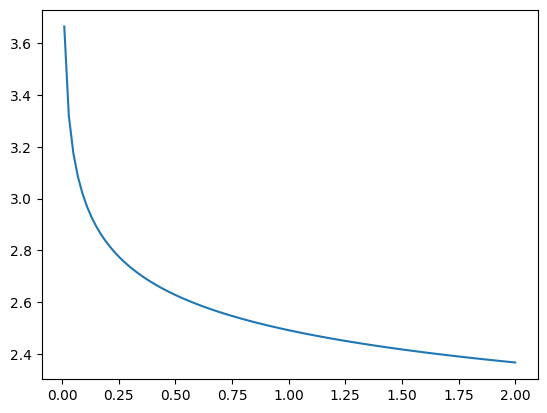

In [6]:
u_plot = np.linspace(0.01,2,100)
ret_plot_model = AnalyticRetardation.freundlich(u_plot, por=cfg.por, rho_s=cfg.rho_s, Kf=cfg.Kf, nf=cfg.nf)
plt.plot(u_plot, ret_plot_model)
plt.show()

In [7]:
np.save("/Users/r/Documents/dev/tmp/finn_repo_comparisions/timo_finn/python/diffusion_sorption/experimental_data/data/ret_phys_model_core2.npy", ret_plot_model)

In [8]:
c_measured.std(), c_measured.mean()

(2.0790164699507967, 2.776701817854545)

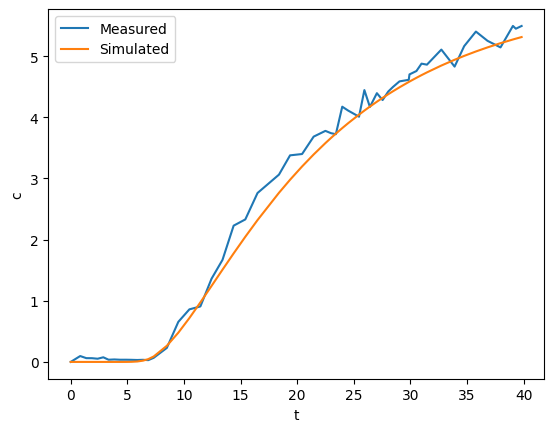

In [9]:
plt.plot(t, c_measured, label="Measured")
plt.plot(t, c_simulated, label="Simulated")
plt.xlabel("t")
plt.ylabel("c")
plt.legend()
plt.show()

In [10]:
u0 = torch.zeros(cfg.num_vars, cfg.Nx, 1)

In [11]:
model = ConcentrationPredictor(
    u0=u0,
    cfg=cfg,
    ret_inv_funs=[
        create_mlp([1, 15, 15, 15, 1], nn.Tanh(), nn.Sigmoid()),
        None,
    ],
)

In [12]:
output_dir.mkdir(parents=True, exist_ok=True)
with open(output_dir / "input.json", "w") as f:
    json.dump(input_dir, f, indent=4)

In [13]:
t_train = torch.from_numpy(t)
Y_train = torch.from_numpy(c_measured)

In [14]:
# Train the model
model.run_training(
    t=t_train,
    u_train=Y_train,
    out_dir=output_dir,
    max_epochs=max_epochs,
)

Training: Epoch [2/100], Training Loss: 1.591e+04, Runtime: 169.61 secs
Training: Epoch [3/100], Training Loss: 1.591e+04, Runtime: 271.23 secs
Training: Epoch [4/100], Training Loss: 1.591e+04, Runtime: 281.27 secs
Training: Epoch [5/100], Training Loss: 1.591e+04, Runtime: 287.02 secs
Training: Epoch [6/100], Training Loss: 1.591e+04, Runtime: 288.05 secs
Training: Epoch [7/100], Training Loss: 1.591e+04, Runtime: 293.71 secs
Training: Epoch [8/100], Training Loss: 1.591e+04, Runtime: 291.33 secs
Training: Epoch [9/100], Training Loss: 1.591e+04, Runtime: 292.11 secs
Training: Epoch [10/100], Training Loss: 1.591e+04, Runtime: 288.44 secs
Training: Epoch [11/100], Training Loss: 1.591e+04, Runtime: 282.80 secs
Training: Epoch [12/100], Training Loss: 1.591e+04, Runtime: 287.71 secs


KeyboardInterrupt: 

In [121]:
model.eval()
with torch.no_grad():
    c_predictions = model(t)
np.save(output_dir / "c_full_predictions.npy", c_predictions.detach().numpy())
np.save(output_dir / "c_train_predictions.npy", c_predictions.detach().numpy())

AssertionError: t must be a torch.Tensor